# Kaggle Heartquake

Ce notebook se base sur le projet Kaggle Hearthquake : https://www.kaggle.com/c/LANL-Earthquake-Prediction/overview

Le travail a été produit par Nicolas Fley, Romain Pelloie et Julien Raspaud dans le cadre du projet DaC (Données à la Connaissances).

Ce projet a été choisi pour deux principales raisons :

- Le fait qu'il se base sur des "times series", type de données auquel nous n'avions pas encore été confrontés.
- Le fait que ce soit un projet Kaggle avec prix à la clé, en effet cela nous assure la qualité des données d'entrainement.

Ce notebook est composé de cinq parties :

- Préambules (librairies et informations générales)
- Découverte du dataset d'entrainement et de test
- Extraction des features et entrainement
- Submission
- Amélioration

### Préambule 
#### Librairies

In [1]:
# utilitaire de listage de fichier dans des répertoires
import glob

# librairies de manipulation de données
import pandas as pd # utilisé pour lire les csv et créer des dataframe.
import numpy as np

# preprocessing
from sklearn.preprocessing import StandardScaler

# features
from tqdm import tqdm # permet d'afficher l'avancement de l'extraction des features
from scipy.stats import kurtosis

# model d'entrainement
from sklearn.svm import NuSVR
from sklearn.ensemble import RandomForestRegressor

# evaluation
from sklearn.metrics import mean_absolute_error

# affichage
from matplotlib import pyplot as plt

#### Seismologie

Nous avons compris le fonctionnement des séismes et le lien avec les `ondes acoustiques` par le biais de cette vidéos : https://www.youtube.com/watch?v=uA_OLKfQpYA

Nous apprenons qu'un seisme est détecté par 3 grosses variations acoustiques. Il y a d'abord des P-Wave (Primary/Pressure Wave) puis des S-Wave (Secondary Wave) avant d'arriver aux Surface Wave qui sont les plus fortes et celles ressenties à la surface par les habitants. Ces 3 ondes sont surtout utilisés pour localiser l'epicentre des seismes et les P-Wave peuvent dans une certaines mesure être detectées pour prévenir la population quelques minutes avant que les ondes surfacique soient ressenties.

Néanmoins, ce projet n'est pas focalisé sur ces 3 types d'ondes, en effet, le dataset est issu de mesures effectuées expérimentalement en laboratoire. Nous devons déterminé, en se basant sur l'ondes acoustique relevée, le temps qu'il reste avant le prochain séisme.

Contrairement à ce que nous pensions au départ, le but n'est donc pas de détecter ces 3 ondes mais d'utiliser les ondes acoustiques relevées par le sismographe du laboratoire afin d'en extraire des features ou des motifs permettant de détecter avec précision le moment de la prochaine rupture.

## Découverte du dataset d'entrainement et de test

Le dataset fourni est très gros, il fait 10Go. Nous avons donc commencé par extraire les 10_000_000 premières valeurs du dataset (153 Mo) afin de pouvoir les traiter plus facilement.

#### Généralités sur les valeurs

Ce dataset contient deux colonnes.
La première colonne est nommée `acoustic_data` qui contient les valeurs entières dont la répartition reste à définir. On notera néanmoins grâce à la seconde cellule représentant 50 valeurs qu'elles sont réparties et ne suivent pas de motif à première vue.
La seconde colonne est nommée `time_to_failure` et contient une valeur flottante faisant référence au temps restant avant la prochaine rupture.

On notera qu'il se passe environ une nanoseconde entre deux mesures, l'échantillonnage est d'environ 1Ghz.

In [4]:
def load_data(file_name):
    data = pd.read_csv(file_name,dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
    return data

In [56]:
small_data = load_data("data/train_small.csv")
print(f'Taille du small dataset : {len(small_data)}')
pd.set_option('float_format', '{:.11}'.format)
data[:10]

Taille du small dataset : 9999999


,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.469099981
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


In [44]:
print(list(small_data['acoustic_data'][:50]))

[12, 6, 8, 5, 8, 8, 9, 7, -5, 3, 5, 2, 2, 3, -1, 5, 6, 4, 3, 5, 4, 2, 6, 7, 7, 8, 14, 9, 4, 7, 4, 3, 4, 8, 6, 4, 11, 9, 4, 3, 0, 3, 6, 3, 4, 2, 3, 10, 6, 8]


#### Affichage et répartition temporelle

Nous avons affiché les valeurs selon différentes échelles, après plusieurs tests nous avons remarqué que le dataset était constitué d'une multitude d'ensembles de 4096 points espacés dans le temps. Nous allons parcourir les différentes échelles et en extraire les informations utiles.

- **200 points** (~200ns) : pas de motif apparent, le signal semble très bruité à cette échelle.
- **4096 points** (~4us) : le signal semble plus intéressant, des valeurs semblent pouvoir être extraites de ce type de signal.
- **next 4096 points** (~4us) : idem, on notera un décalage d'une milliseconde avec le précédent signal, il n'y a pas de lien direct visible avec les 4096 points précédentts
- **20_000 points** (~5ms) : on détecte sur ce graphique la mesure, effectuée toutes les millisecondes des 4096 points.
- **time to failure** (~2.5s) : ce graphique représente la variation de la grandeur `time to failure`, on notera que l'on commence à environ 2s, que l'on descend à 0 et que l'on reprend à 12 pour descendre vers 10s.
- **10_000_000 points** (~2.5s) : on note une grosse amplitude aux alentours des 0ms, on voit aussi les limites de cet affichage. En effet on se rend compte qu'avec ce principe, on lit les points à l'envers (car on utilise le `time to failure` comme coordonnée. On utilisera donc dès à présent une abscisse générale et on mettra le `time to failure` en avant sur l'`acoustic data` comme représenté dans la dernière figure.

Les 10_000_000 de points forment 2441 ensembles de 4096 points, sur cet ensemble, une rupture a eu lieu, le `time to failure` reprenant à une valeur beaucoup plus haute.

Nous pensons donc intuitivement qu'il nous faudrait utiliser ces ensembles de 4096 points afin de déterminer le temps restant avant la prochaine rupture.

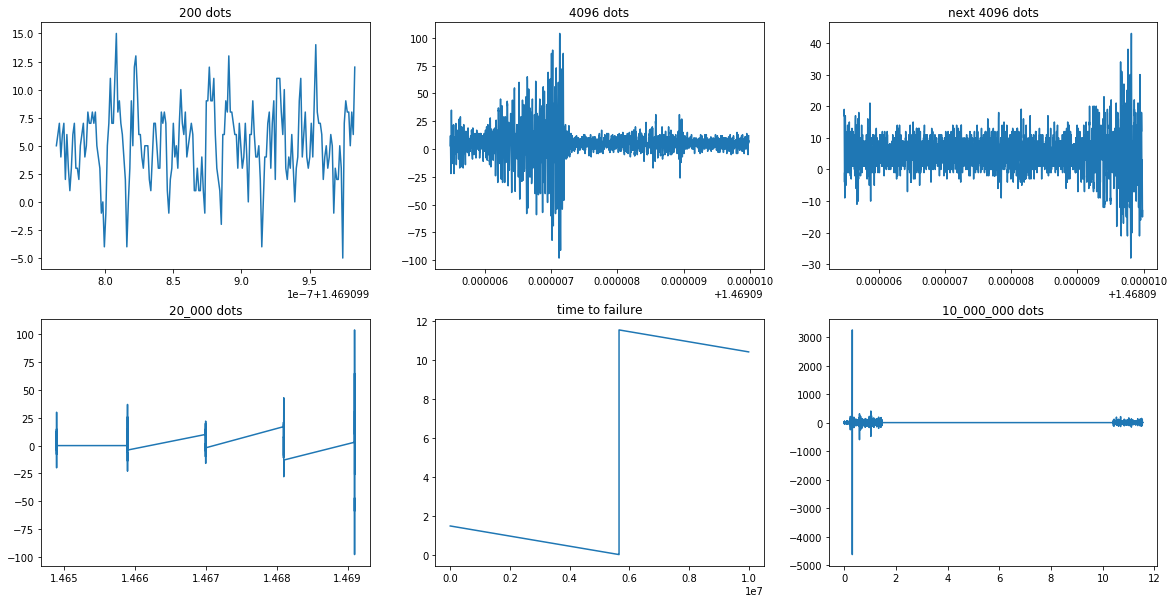

In [51]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.gca().set_title('200 dots')
plt.plot(small_data['time_to_failure'][:200],small_data['acoustic_data'][:200])
plt.subplot(2, 3, 2)
plt.gca().set_title('4096 dots')
plt.plot(small_data['time_to_failure'][:4095],small_data['acoustic_data'][:4095])
plt.subplot(2, 3, 3)
plt.gca().set_title('next 4096 dots')
plt.plot(small_data['time_to_failure'][4095:4095+4096],small_data['acoustic_data'][4095:4095+4096])
plt.subplot(2, 3, 4)
plt.gca().set_title('20_000 dots')
plt.plot(small_data['time_to_failure'][:20000],small_data['acoustic_data'][:20000])
plt.subplot(2, 3, 5)
plt.gca().set_title('time to failure')
plt.plot(small_data['time_to_failure'][:])
plt.subplot(2, 3, 6)
plt.gca().set_title('10_000_000 dots')
plt.plot(small_data['time_to_failure'][:],small_data['acoustic_data'][:])
plt.show()

Text(0, 0.5, 'time_to_failure')

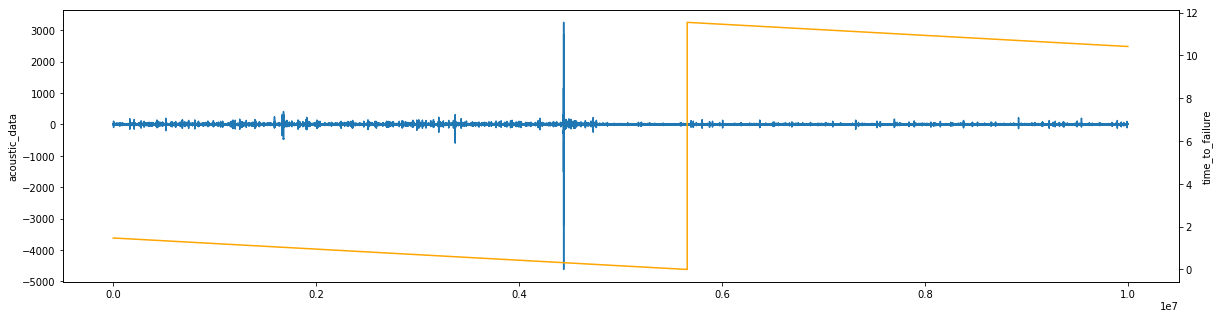

In [55]:
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(111)
ax1.plot(small_data['acoustic_data'][:])
ax1.set_ylabel('acoustic_data')

ax2 = ax1.twinx()
ax2.plot(small_data['time_to_failure'][:], color='orange')
ax2.set_ylabel('time_to_failure')

#### Distribution

En enlevant les valeurs extrêmes, on voit que les valeurs suivent une répartition normale centrée en 4,5 et d'écart type 17,8. Faire un scaling sur l'ensemble de ces valeurs est donc une option à envisager.

moyenne : 4.502072650207265, variance : 17.80707332206766


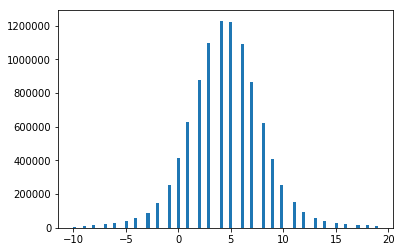

In [66]:
plt.hist(sorted(small_data['acoustic_data'])[100_000:9_900_000],
         bins = 100)
print(f"moyenne : {small_data['acoustic_data'].mean()}, variance : {small_data['acoustic_data'].std()}")
plt.show()

## Extraction des features et entrainement

Nous avons défini une fonction nous permettant d'extraire un certain nombre de features composant chacune une agregation des valeurs d'un ensemble donné.

On extrait ainsi pour chaque ensemble :
- la moyenne
- l'écart type
- la mesure de kurtosis (coefficient d’aplatissement, https://fr.wikipedia.org/wiki/Kurtosis)
- les valeur max, min, et la valeur max en absolu
- 6 quantiles 0.01, 0.05, 0.1, 0.9, 0.95, 0.99

On notera une adaptation de cette fonction permettant de générer selon la volonté de l'utilisateur un ensemble de test ou encore retourner seulement les ensembles de données acoustiques processés.

In [25]:
def preproc_data(data, rows=4_096, is_not_submission=True):
    # create the segments (each row gets a segment value), no need to randomize
    segments = int(np.floor(data.shape[0] / rows))
    
    # first, create dataframes for X and Y
    X = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std','kurt', 'max', 'min','abs_max',
                                'quantile_095','quantile_099','quantile_09',
                                'quantile_01','quantile_005','quantile_001'])
    if is_not_submission:
        Y = pd.DataFrame(index=range(segments), dtype=np.float64,
                               columns=['time_to_failure'])
    
    # split the datasettt into segments to perform agregation calculation on them 
    # should be overlaping segments
    for segment in tqdm(range(segments)):
        seg = data.iloc[segment*rows:segment*rows+rows]
        x = seg['acoustic_data'].values
        if is_not_submission:
            y = seg['time_to_failure'].values[-1]

            # time to failure 
            Y.loc[segment, 'time_to_failure'] = y
        
        # all our features
        X.loc[segment, 'ave'] = x.mean()
        X.loc[segment, 'kurt'] = kurtosis(x)
        X.loc[segment, 'quantile_095'] = np.quantile(x,0.95)
        X.loc[segment, 'quantile_099'] = np.quantile(x,0.99)
        X.loc[segment, 'quantile_09'] = np.quantile(x,0.9)
        X.loc[segment, 'quantile_01'] = np.quantile(x,0.1)
        X.loc[segment, 'quantile_005'] = np.quantile(x,0.05)
        X.loc[segment, 'quantile_001'] = np.quantile(x,0.01)
        X.loc[segment, 'std'] = x.std()
        X.loc[segment, 'max'] = x.max()
        X.loc[segment, 'min'] = x.min()
        X.loc[segment, 'abs_max'] = abs(x).max()
    
    if is_not_submission:
        return X, Y
    return X

#### Entrainement

L'extraction du dataset entier peut prendre du temps

In [6]:
if False:
    data = load_data('data/train.csv')

Nous utilisons le dataset entier afin d'en extraire les features qui nous interessent, nous séparons nos données en sous ensembles de taille 4096 afin de respecter la répartition des données vue précédemment.

Cette étape peut aussi prendre beaucoup de temps.

In [26]:
X, Y = preproc_data(data, rows=4_096)
X.shape

100%|██████████| 153599/153599 [07:54<00:00, 323.66it/s]


(153599, 12)

Nous extrayons de ces features l'ensemble d'entrainement et l'ensemble de test. Comme nous n'optimisons aucun hyper paramètre, une séparation naïve tel que prendre les 90% premiers éléments pour l'entrainement est les 10% restants pour le test est donc normale.

In [28]:
X_train = X[:int(len(X)*0.9)]
Y_train = Y[:int(len(X)*0.9)]
X_test = X[int(len(X)*0.9):]
Y_test = Y[int(len(X)*0.9):]

Nous utilisons l'outil de scaling par défaut 

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Au départ un modèle svm `NuSVR` avait été utilisé, mais sa complexité quadratique semble être trop lente pour nos ordinateurs. Nous avons donc basculé vers un modèle de `RandomForestRegressor` qui semble tout autant apprecié par la communauté.

In [ ]:
# svm = NuSVR()
# svm.fit(X_train_scaled, Y_train.values.flatten(), verbose=True)
# y_pred = svm.predict(X_test_scaled)

In [46]:
rfr = RandomForestRegressor()
rfr.fit(X_train_scaled, Y_train.values.flatten())
y_pred = rfr.predict(X_test_scaled)

/Users/nico/Documents/kaggle-earthquake/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


L'étude de l'importance des features montre que kurtonis, le moyennage et l'écart type sont les grandeur les plus importantes.

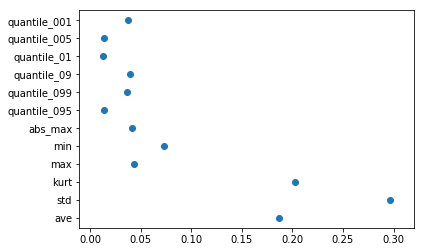

In [45]:
plt.scatter(rfr.feature_importances_,['ave', 'std','kurt', 'max', 'min','abs_max',
                                'quantile_095','quantile_099','quantile_09',
                                'quantile_01','quantile_005','quantile_001'])

Une fonction de moyennage avait été créée, elle permet de réduire le bruit que l'on peut voir sur la cellule suivante. 

In [31]:
def mean(array, step):
    array_len= len(array)
    array_mean = list(array[:])
    mean_step = step
    for i in range(mean_step,array_len):
        array_mean[i] = sum([array[i-j] for j in range(mean_step)])/mean_step
    return array_mean

`y_pred` n'est pas débruité sur la cellule suivante, on note la grande variance de ses valeurs, le moyennage de 36 de ces valeurs permet d'obtenir la figure suivante.

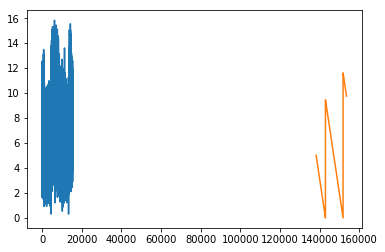

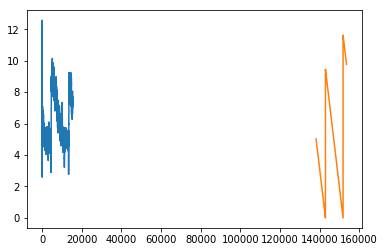

In [32]:
plt.plot(y_pred)
plt.plot(Y_test)
plt.show()

y_pred_mean = mean(y_pred,36)
plt.plot(y_pred_mean)
plt.plot(Y_test)
plt.show()

In [33]:
for i in range(1,40):
    y_pred_mean = mean(y_pred,i)
    score = mean_absolute_error(Y_test.values.flatten(), y_pred_mean)
    print(f'mean: {i}, Score: {score:0.3f}')

mean: 1, Score: 2.607
mean: 2, Score: 2.407
mean: 3, Score: 2.327
mean: 4, Score: 2.282
mean: 5, Score: 2.255
mean: 6, Score: 2.236
mean: 7, Score: 2.222
mean: 8, Score: 2.210
mean: 9, Score: 2.200
mean: 10, Score: 2.192
mean: 11, Score: 2.185
mean: 12, Score: 2.180
mean: 13, Score: 2.175
mean: 14, Score: 2.171
mean: 15, Score: 2.168
mean: 16, Score: 2.165
mean: 17, Score: 2.162
mean: 18, Score: 2.160
mean: 19, Score: 2.158
mean: 20, Score: 2.156
mean: 21, Score: 2.154
mean: 22, Score: 2.153
mean: 23, Score: 2.151
mean: 24, Score: 2.150
mean: 25, Score: 2.149
mean: 26, Score: 2.148
mean: 27, Score: 2.147
mean: 28, Score: 2.146
mean: 29, Score: 2.146
mean: 30, Score: 2.145
mean: 31, Score: 2.144
mean: 32, Score: 2.143
mean: 33, Score: 2.143
mean: 34, Score: 2.142
mean: 35, Score: 2.142
mean: 36, Score: 2.141
mean: 37, Score: 2.140
mean: 38, Score: 2.140
mean: 39, Score: 2.139


### Submission

Certaines notions précédement utilisées sont expliquées ici. En effet, le test de notre algorithme par Kaggle se fait par la prédiction de 2624 valeurs, chacune grâce à un échantillon de 150_000 valeurs. Une seule valeur doit être envoyée pour l'ensemble de ces 150_000 valeurs. Le score est déterminé par une Mean Absolute Error.
La solution utilisée a donc été un moyennage. Cette solution est justifiable par le fait que l'on voit que moyenner la prédiction de 36 ensemble ne semble faire que diminuer la MAE.

In [ ]:
results = [['seg_id','time_to_failure']]
for test_file in glob.glob('data/test/*'):
    test_data = load_data(test_file)
    X_train_test = preproc_data(test_data, is_not_submission=False)
    X_train_test_scaled = scaler.transform(X_train_test)
    y_pred_test = rfr.predict(X_train_test_scaled)
    y_pred_test_value = sum(y_pred_test)/len(y_pred_test)
    results.append([test_file.split('/')[2], y_pred_test_value])

Enfin, nous mettons en forme le résultat pour l'envoyer à Kaggle. Notre erreur MAE annoncée est de 2.257 et notre classement est 2324 sur 2700.

In [36]:
for result in results:
    result[0] = result[0].split('.')[0]
with open('result.csv','w+') as f:
    f.write('\n'.join([','.join([str(rr) for rr in r]) for r in results]))

### Amélioration

Une solution pour augmenter notre score a été d'utiliser NuSVR et entrainer notre ensemble de donnée sur la totalité de l'ensemble de test, donc 150_000 points, notre MAE annoncée passe alors à 1.639 et notre classement monte 1853ème : https://www.kaggle.com/c/LANL-Earthquake-Prediction/leaderboard (nous sommes CS-DAC-Team)

On pourra expliquer cette situation par l'importance que doivent avoir les valeurs extrêmes et qui sont étoufféss par la moyenne, ce qui semble néanmoins étonnant au regard de la MAE.

Cela est d'autant plus étonnant que notre MAE personnelle est d'environ 2.1 en prenant des sample de 4096 valeurs et qu'elle monte à 2.3 en prenant des sample de 150_000 valeurs.

Augmenter notre nombre de features et/ou faire de la grid search sur les hyperparamètres de notre modèle de RandomTreeRegressor pourrait nous permettre d'améliorer ce score.